Train one XGBoost model to predict streamflow for all stations. Forcings are aggregated from hourly to daily to match streamflow resolution. RandomSearchCV to find good parameters.

Use NSE custom objective.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190909-072525'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
param_dist = {
    #'max_depth': sp.stats.randint(2, 8),
    'learning_rate': sp.stats.uniform(0.005, 0.1),
    #'gamma': sp.stats.uniform(0, 5),
    #'min_child_weight': sp.stats.randint(1, 30),
    'subsample': sp.stats.uniform(0.4, 0.1),
    #'colsample_bytree': sp.stats.uniform(0.3, 0.7),
    #'colsample_bylevel': sp.stats.uniform(0.3, 0.7),
    'reg_alpha': sp.stats.expon(0, 20),
    'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
class NSEObjective:
    """Custom NSE XGBoost objective.
    
    This is a bit of a hack: We use a unique dummy target value for each sample, allowing us to look up
    the mean that corresponds to the sample's station.
    When calculating the loss, we replace the dummy with the actual target, so the model learns the right thing.
    """
    def __init__(self, dummy_target, actual_target, means, stations):
        self.dummy_target = dummy_target.to_numpy()
        self.actual_target = actual_target.to_numpy()
        self.means = means.to_numpy()
        self.stations = stations.to_numpy()
        
    def nse_objective(self, y_true, y_pred):
        """ NSE objective for XGBoost, slightly modified to normalize with mean """
        indices = np.searchsorted(self.dummy_target, y_true)
        actual_target = self.actual_target[indices]
        means = self.means[indices]
        stations = self.stations[indices]
        grad, hess = np.empty(len(y_pred)), np.empty(len(y_pred))
        for station in np.unique(stations):
            station_mask = stations == station
            # normalize with mean instead of sum, because otherwise the gradients would be too small.
            normalization = np.mean(np.square(actual_target[station_mask] - means[station_mask]))
            grad[station_mask] = 2 * (y_pred[station_mask] - actual_target[station_mask]) / normalization
            hess[station_mask] = 2.0 / normalization
        return grad, hess
    
    def nse(self, y_pred, y_true, means):
        return np.sum(np.square(y_pred - y_true)) / np.sum(np.square(y_true - means))
    
    def nse_metric(self, y_pred, y_true):
        """ NSE metric for XGBoost """
        indices = np.searchsorted(self.dummy_target, y_true.get_label())
        actual_target = self.actual_target[indices]
        stations = self.stations[indices]
        means = self.means[indices]
        unique_stations = np.unique(stations)
        nse = 0.0
        # group by station to calculate NSE per station, then average
        for station in unique_stations:
            station_mask = stations == station
            nse += self.nse(y_pred[station_mask], actual_target[station_mask], means[station_mask])
        
        return 'nse', nse / len(unique_stations)
    
    def neg_nse_metric_sklearn(self, estimator, X, y_true):
        """ -NSE metric for sklearn """
        y_pred = estimator.predict(X)
        indices = np.searchsorted(self.dummy_target, y_true)
        actual_target = self.actual_target[indices]
        stations = self.stations[indices]
        means = self.means[indices]
        unique_stations = np.unique(stations)
        nse = 0.0
        # group by station to calculate NSE per station, then average
        for station in unique_stations:
            station_mask = stations == station
            nse += self.nse(y_pred[station_mask], actual_target[station_mask], means[station_mask])
        
        return -nse / len(unique_stations)

In [5]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

data = data.join(pd.get_dummies(data['station'], prefix='station'))
print(data.shape)

data['dummy_target'] = range(len(data))
means = data.groupby('station')['runoff'].mean()
data = data.join(means, on='station', rsuffix='_mean')
nse_loss = NSEObjective(data['dummy_target'], data['runoff'], data['runoff_mean'], data['station'])

train = data[(data['date'] >= train_start) & (data['date'] <= train_end)].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()

test = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), train['dummy_target']), 
       (val.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), val['dummy_target'])]

xgb_model = xgb.XGBRegressor(n_estimators=1000, colsample_bylevel=0.9237069325689322, colsample_bytree=0.4540275483264704, gamma=0.9980644706841152, max_depth=7, min_child_weight=1, subsample=0.4831765844168827, objective=nse_loss.nse_objective, n_jobs=1, random_state=123)
m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=1000, cv=2, return_train_score=True, scoring=nse_loss.neg_nse_metric_sklearn, n_jobs=-1, random_state=123, verbose=5)
m.fit(train.drop(['station', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1), train['dummy_target'], eval_set=val, 
              eval_metric=nse_loss.nse_metric, early_stopping_rounds=100, verbose=False)

cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
print('Best params: {}'.format(m.best_params_))
print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])

test = test[~pd.isna(test['runoff'])]

predict = test.copy()
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff', 'dummy_target', 'runoff_mean'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(82918, 8773)
Shapes: train (44081, 8775), val (4897, 8775), test (33580, 8775)
Fitting 2 folds for each of 1000 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 79.8min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed: 131.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 190.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 270.6min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 355.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 445.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 541.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isi

    param_learning_rate param_reg_alpha param_reg_lambda param_subsample  \
937           0.0812363         3.71255         0.018283        0.468914   
586           0.0911808         2.80137        0.0660085        0.426694   
123           0.0952557         5.02461       0.00163782         0.49806   
508           0.0682817         2.04133         0.566025        0.485513   
627            0.102069        0.358548          2.78035        0.486415   

     mean_test_score  mean_train_score  
937        -0.664012         -0.540435  
586        -0.664077         -0.528462  
123        -0.665744         -0.545025  
508        -0.668590         -0.547851  
627        -0.672671         -0.554932  
Best params: {'learning_rate': 0.08123625637629309, 'reg_alpha': 3.7125525377954642, 'reg_lambda': 0.0182830417835344, 'subsample': 0.46891424528247516}
mean_train_score   -0.540435
mean_test_score    -0.664012
Name: 937, dtype: object


02GA010 	NSE: 0.3349362521873349 	MSE: 317.0848028696895 (clipped to 0)
02GA018 	NSE: 0.35120477925189486 	MSE: 162.94698318540836 (clipped to 0)
02GA038 	NSE: 0.29028869137597957 	MSE: 116.77480358602439 (clipped to 0)
02GA047 	NSE: 0.28066531033062403 	MSE: 56.38866406532556 (clipped to 0)
02GB001 	NSE: 0.08415761795395327 	MSE: 6877.861990756637 (clipped to 0)
02GB007 	NSE: 0.4397265289497456 	MSE: 17.52088012674118 (clipped to 0)
02GC002 	NSE: 0.48358909930616123 	MSE: 66.36036785026046 (clipped to 0)
02GC007 	NSE: 0.5048426991275222 	MSE: 14.914803628302407 (clipped to 0)
02GC010 	NSE: 0.5265069760905562 	MSE: 28.149122296739908 (clipped to 0)
02GC018 	NSE: 0.5025432037700315 	MSE: 33.69115780457439 (clipped to 0)
02GC026 	NSE: 0.5385723777847826 	MSE: 74.21267494874111 (clipped to 0)
02GD004 	NSE: 0.477658439866829 	MSE: 28.761731672258154 (clipped to 0)
02GE007 	NSE: 0.4137476161763768 	MSE: 21.20771426864119 (clipped to 0)
02GG002 	NSE: 0.5139370774870814 	MSE: 117.230029473323

../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04164000 	NSE: 0.45326820943505375 	MSE: 95.80236700476308 (clipped to 0)
04165500 	NSE: 0.46864468892979705 	MSE: 237.86594361307797 (clipped to 0)
04166100 	NSE: 0.5189788055008794 	MSE: 3.527476422808173 (clipped to 0)
04166500 	NSE: 0.5709296508647002 	MSE: 14.830512989525015 (clipped to 0)
04174500 	NSE: 0.3888169422693979 	MSE: 57.80217109904792 (clipped to 0)
04176500 	NSE: 0.20936386016789044 	MSE: 540.0631616521152 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04177000 	NSE: 0.3524956067033366 	MSE: 17.45013320125045 (clipped to 0)
04193500 	NSE: -0.2926715035597385 	MSE: 91522.11100921097 (clipped to 0)
04195820 	NSE: -0.12611488565910411 	MSE: 1321.8272736472147 (clipped to 0)
04196800 	NSE: 0.2283254366007631 	MSE: 230.9224455366514 (clipped to 0)
04197100 	NSE: 0.38931918654197195 	MSE: 62.63411717391204 (clipped to 0)
04198000 	NSE: 0.08863746353586877 	MSE: 6732.744874826659 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04199000 	NSE: 0.24387518602015723 	MSE: 773.2157298257383 (clipped to 0)
04199500 	NSE: 0.23401605475934517 	MSE: 309.95396489323696 (clipped to 0)
04200500 	NSE: 0.16503080164229633 	MSE: 835.5578148268594 (clipped to 0)
04207200 	NSE: 0.4241282828041759 	MSE: 13.479021161081796 (clipped to 0)
04208504 	NSE: 0.3162656214955375 	MSE: 667.6862138203553 (clipped to 0)
04209000 	NSE: 0.39763238272033496 	MSE: 188.33385938546073 (clipped to 0)
04212100 	NSE: 0.28237554112493 	MSE: 1053.7059603631171 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04213000 	NSE: 0.3240837720958123 	MSE: 121.30616928092928 (clipped to 0)
04213500 	NSE: 0.3156979104237786 	MSE: 701.0105865470535 (clipped to 0)
04214500 	NSE: 0.5141464773047496 	MSE: 58.563368361103564 (clipped to 0)
04215000 	NSE: 0.45460907713241694 	MSE: 52.38633222782416 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04215500 	NSE: 0.4792788564681615 	MSE: 94.03438164521933 (clipped to 0)
Median NSE (clipped to 0) 0.4139680408331431 / Min -0.2926715035597385 / Max 0.5905402844804838
Median MSE (clipped to 0) 92.57968662999502 / Min 3.527476422808173 / Max 91522.11100921097


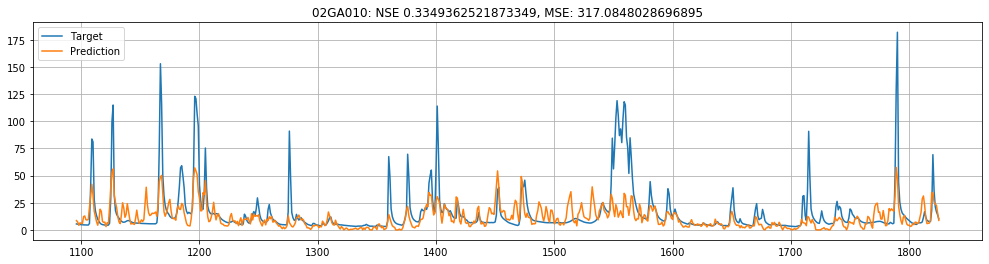

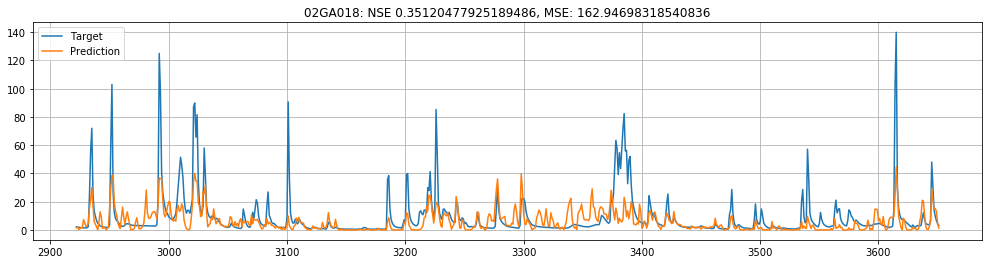

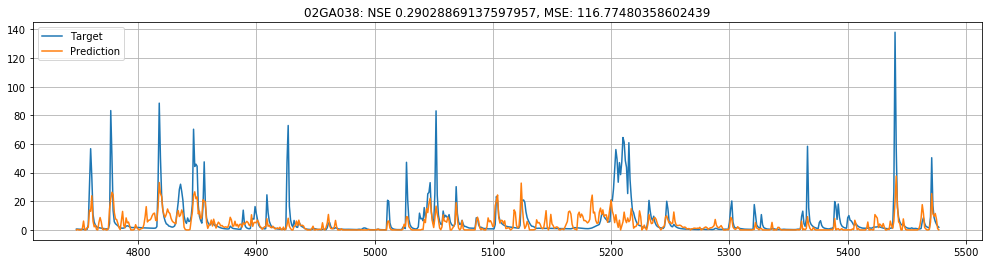

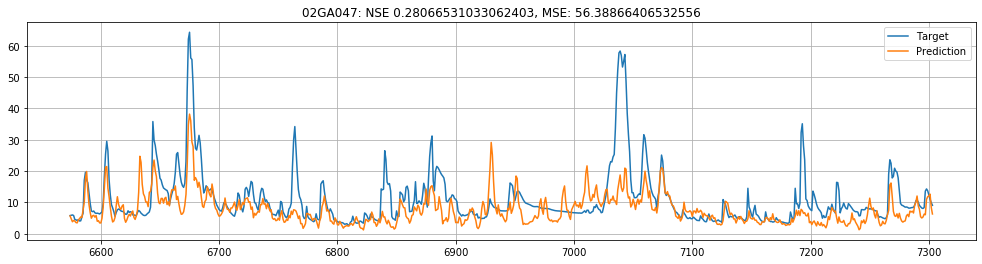

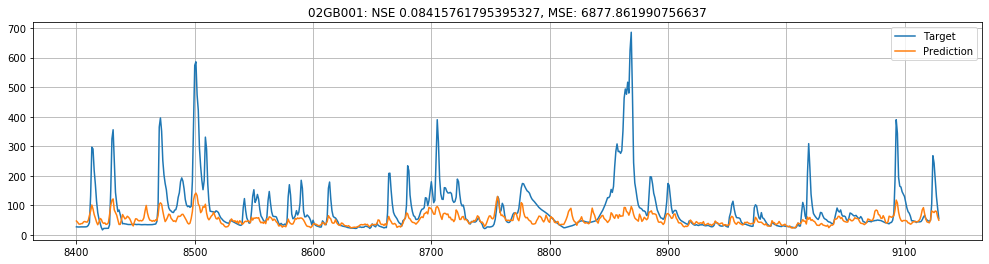

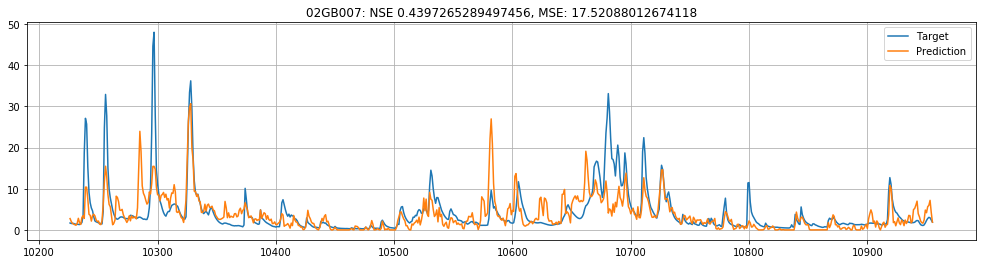

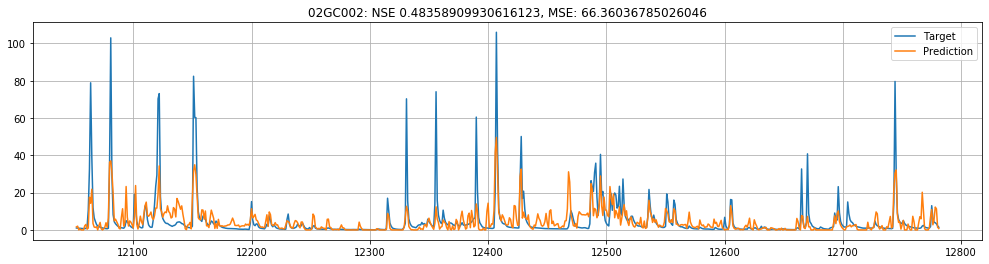

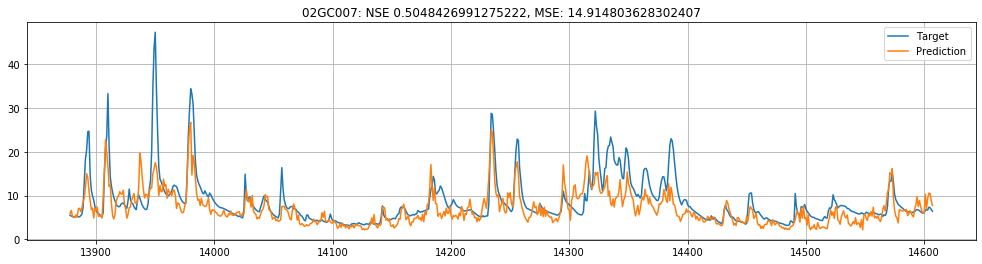

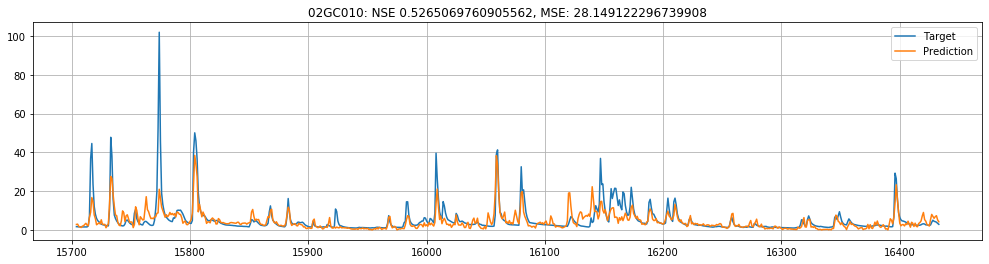

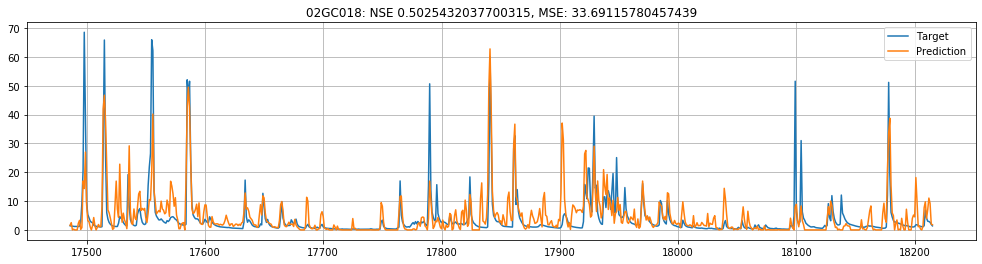

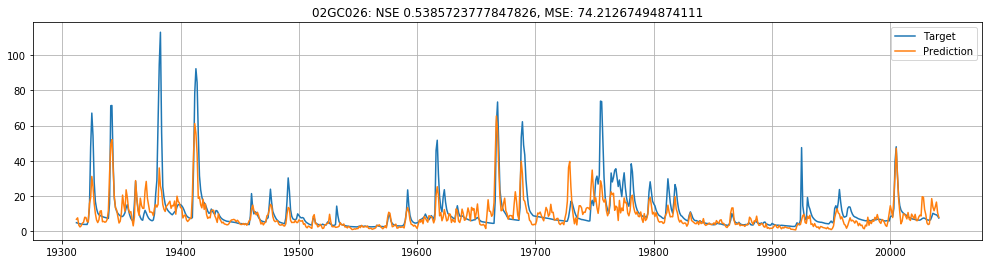

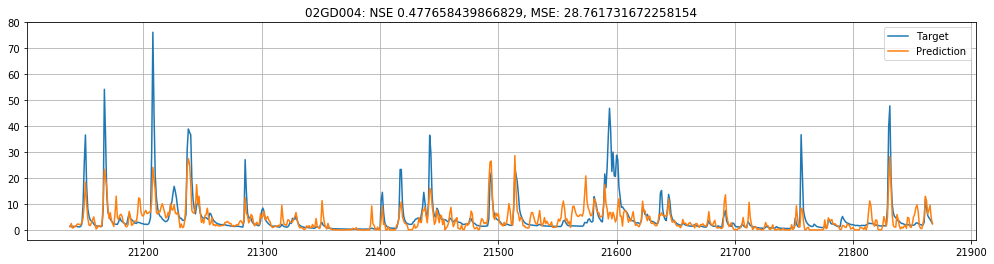

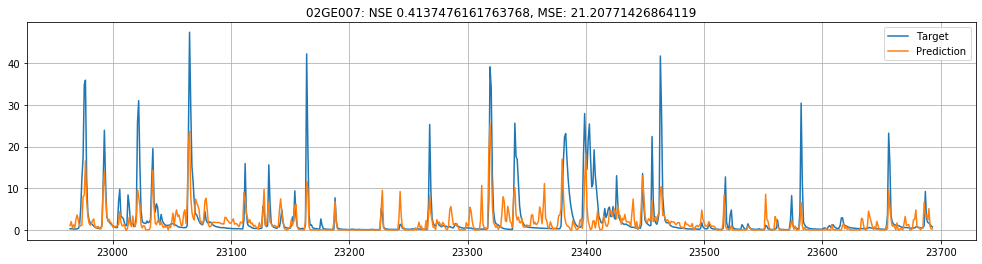

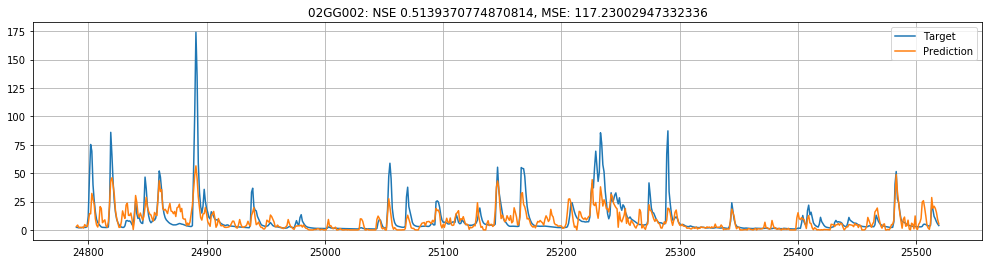

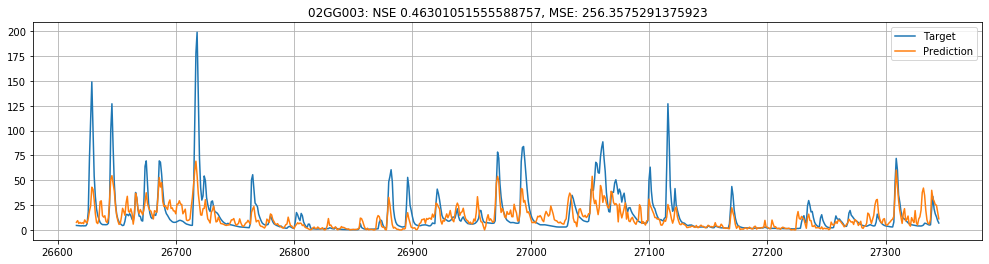

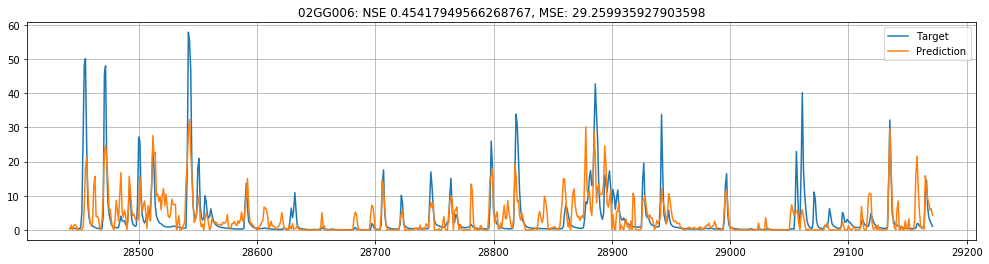

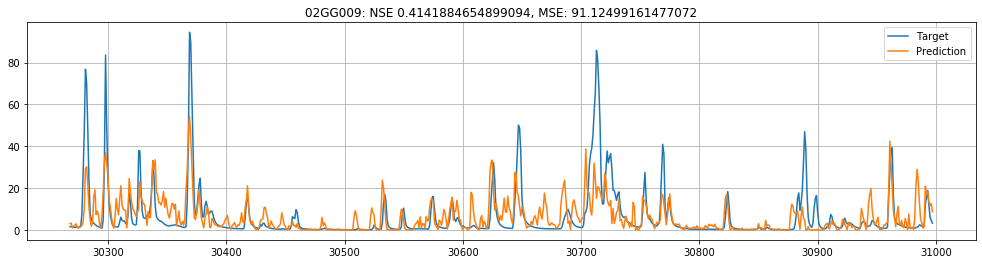

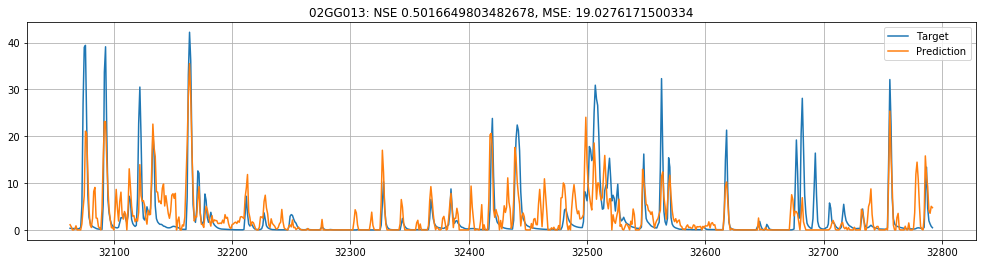

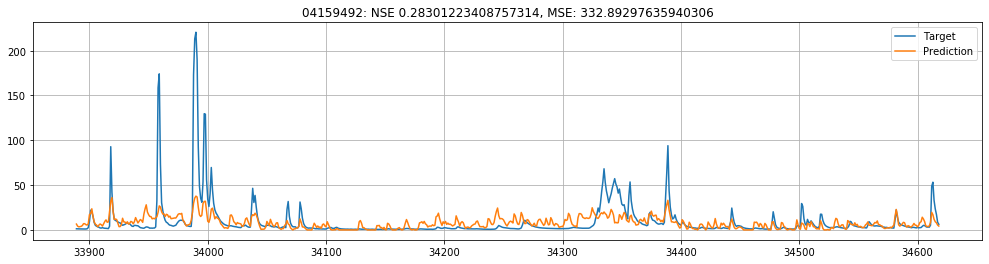

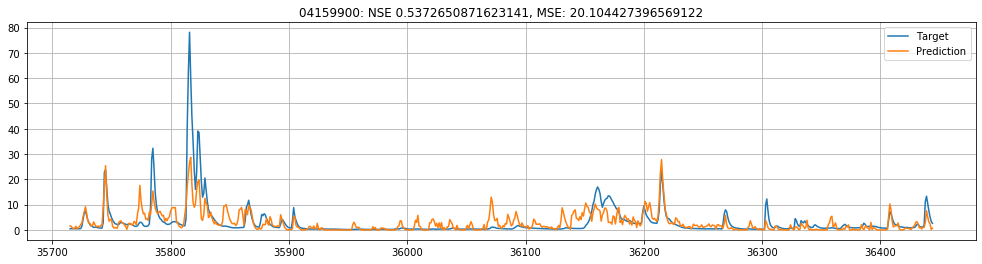

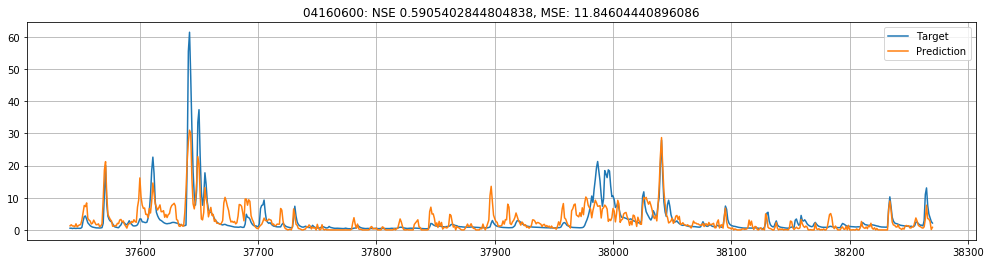

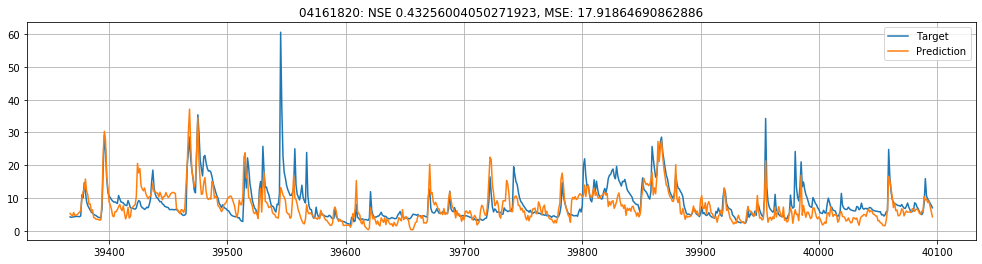

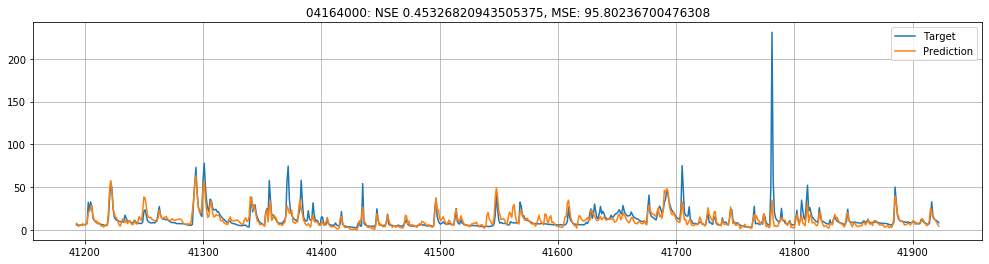

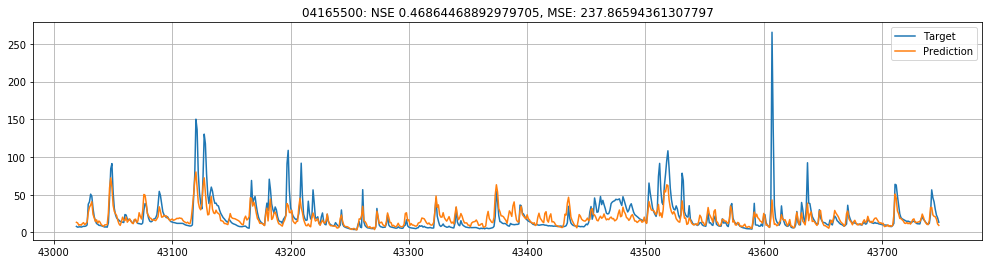

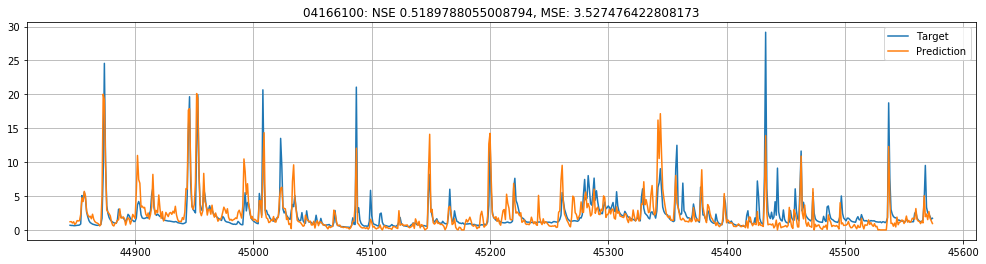

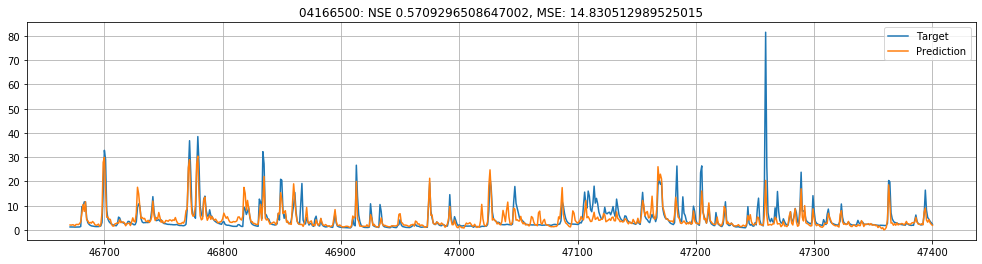

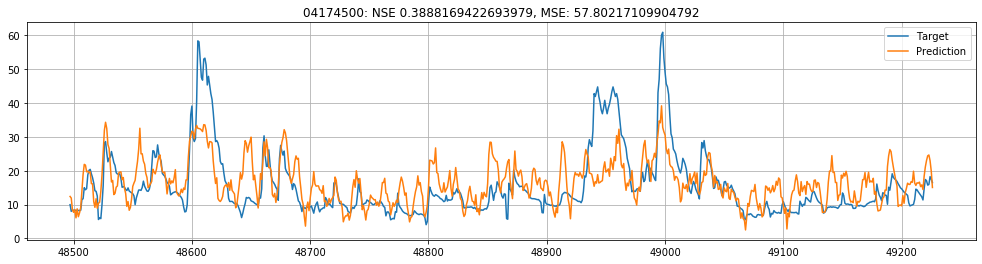

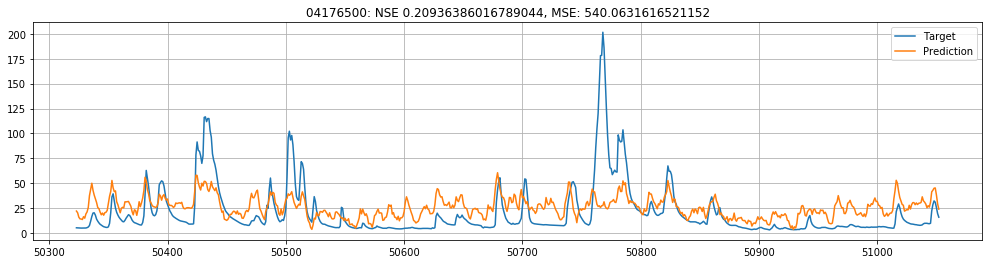

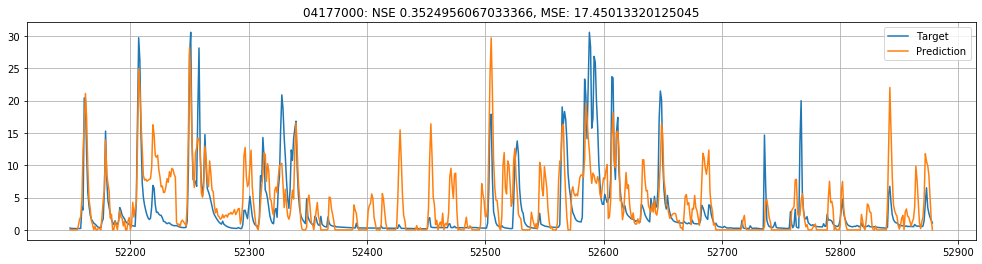

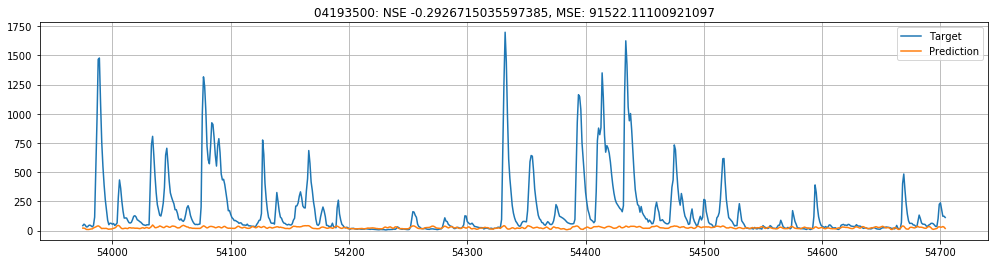

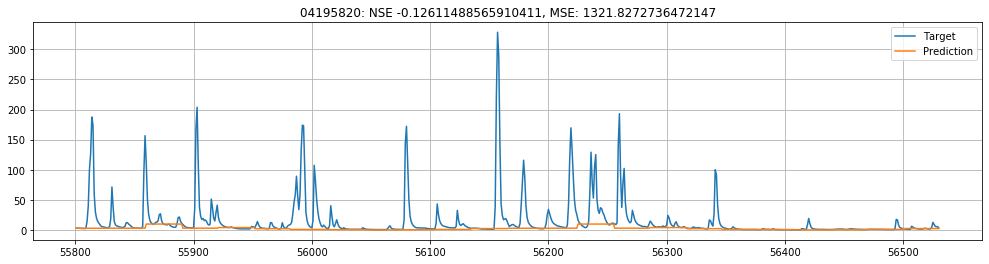

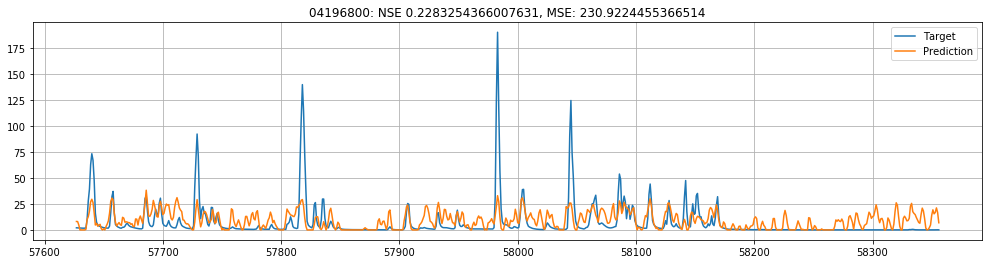

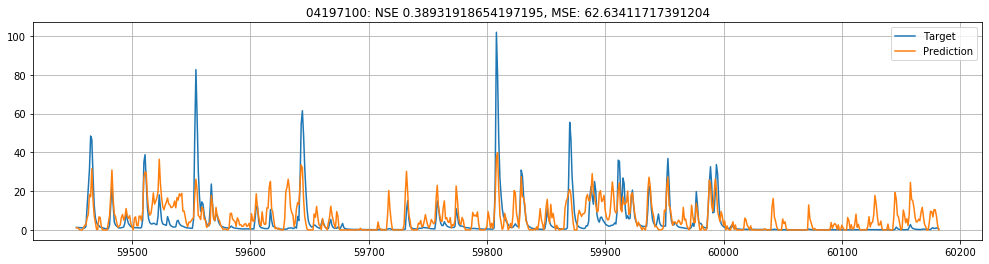

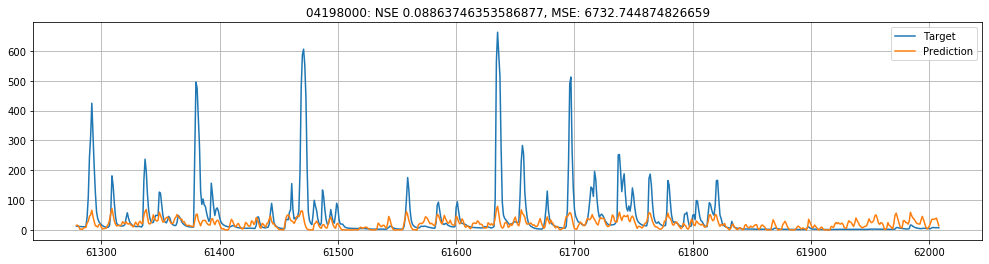

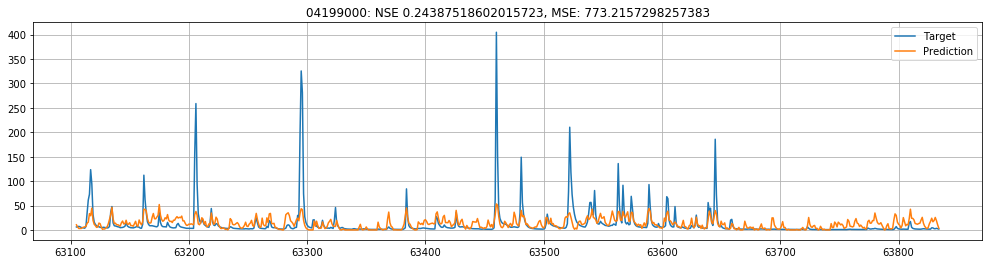

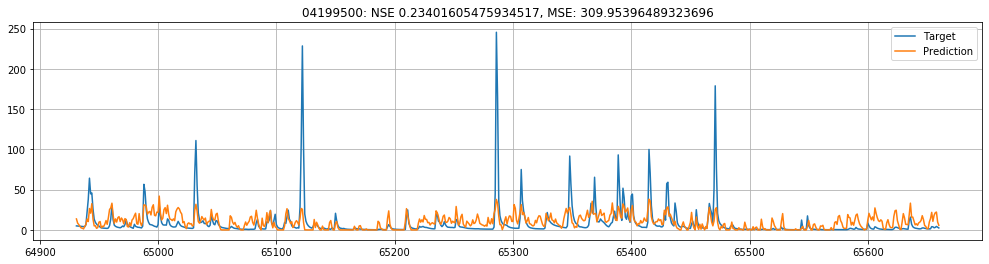

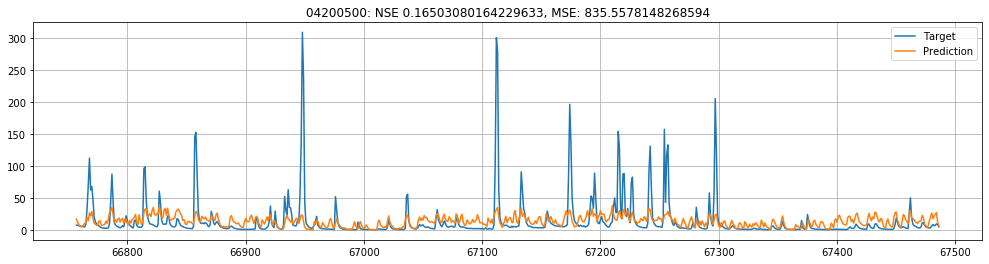

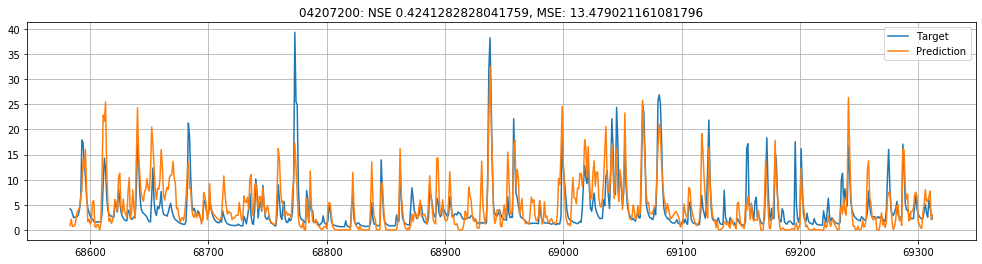

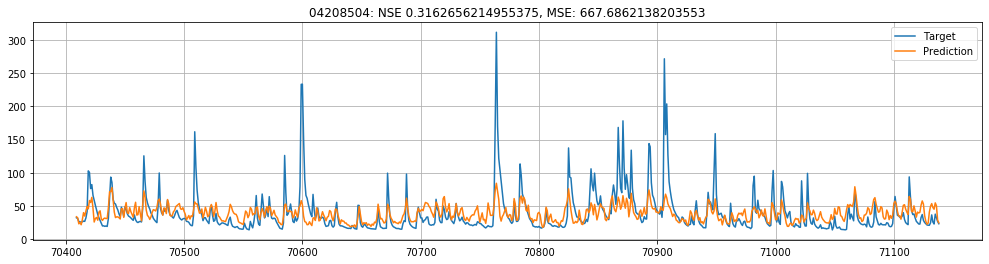

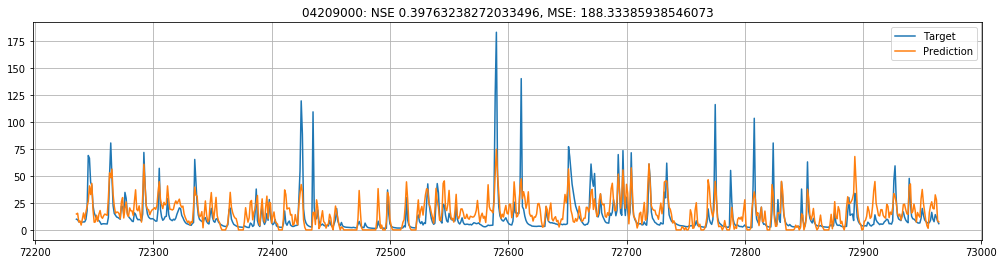

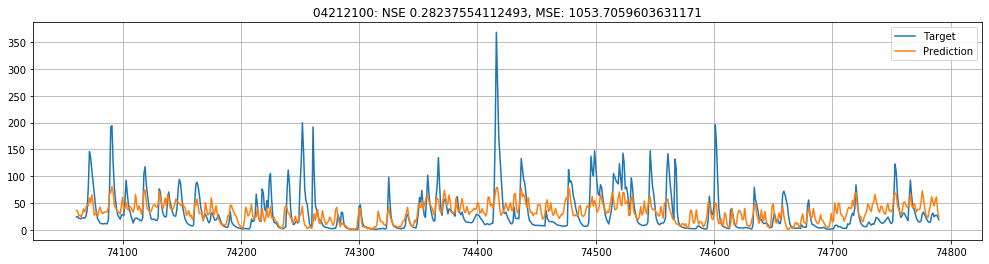

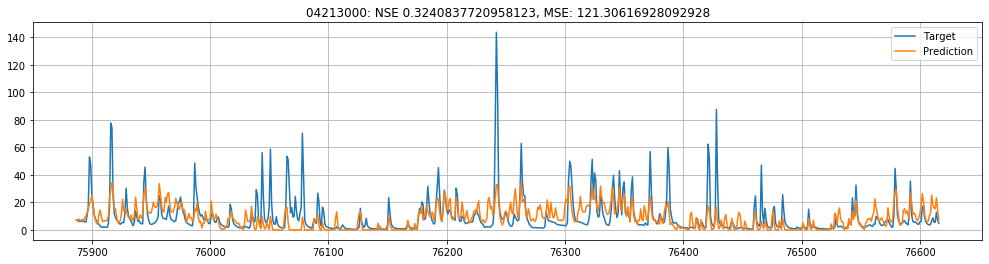

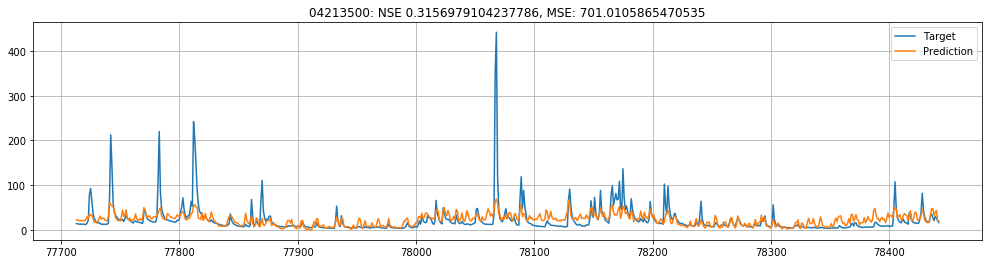

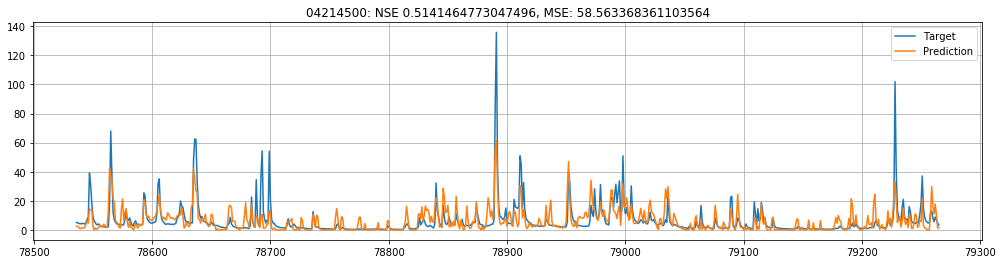

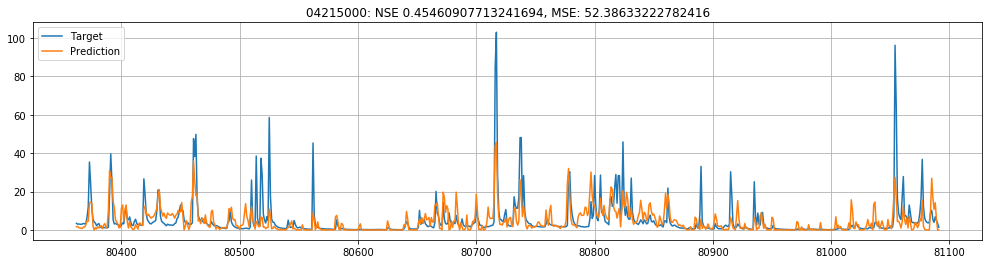

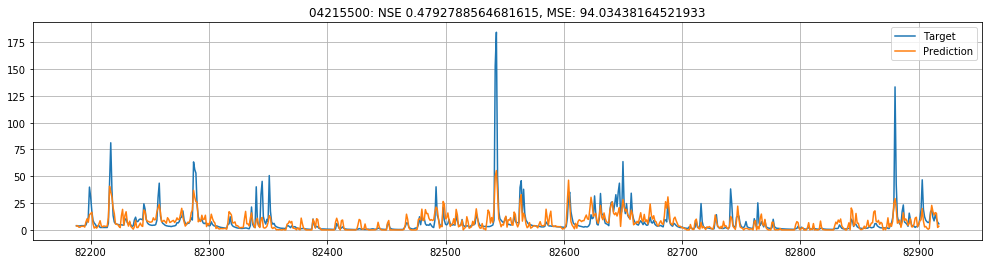

In [6]:
nse_list = []
mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [7]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_oneModel-NSELoss', predict[['date', 'station', 'runoff', 'actual']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_oneModel-NSELoss_20190909-072525.pkl'

In [8]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_oneModel-NSELoss', m, 'all', time_stamp, model_type='sklearn')

Saved model as /home/mgauch/runoff-nn/src/../pickle/models/XGBoost_VIC_aggregateForcings_oneModel-NSELoss_all_20190909-072525.pkl


In [9]:
datetime.now().strftime('%Y%m%d-%H%M%S')

'20190909-165455'